In [273]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict

In [77]:
attribution = pd.read_csv('attribution data.csv')
attribution = attribution.sort_values(['cookie', 'time'], ascending=[False, True])
attribution['visit_order'] = attribution.groupby('cookie').cumcount() + 1
att_path = attribution.groupby('cookie')['channel'].aggregate(
                                lambda x: x.unique().tolist()).reset_index()
att_last_interact = attribution.drop_duplicates('cookie', keep='last')[['cookie', 'conversion']]
att = pd.merge(att_path, att_last_interact, how='left', on='cookie')
att.loc[att['conversion']==0, 'path'] = att.loc[att['conversion']==0, 
                                                'channel'].apply(lambda x: ['start']+x+['null'])
att.loc[att['conversion']==1, 'path'] = att.loc[att['conversion']==1, 
                                                'channel'].apply(lambda x: ['start']+x+['conversion'])
att = att[['cookie', 'path']]

In [78]:
att

,cookie,path
0,00000FkCnDfDDf0iC97iC703B,"[start, Instagram, Online Display, null]"
1,0000nACkD9nFkBBDECD3ki00E,"[start, Paid Search, null]"
2,0003EfE37E93D0BC03iBhBBhF,"[start, Paid Search, null]"
3,00073CFE3FoFCn70fBhB3kfon,"[start, Instagram, null]"
4,00079hhBkDF3k3kDkiFi9EFAD,"[start, Paid Search, null]"
...,...,...
240103,ooooE0hkAFBkED90ChDDiBFAf,"[start, Online Display, null]"
240104,ooooEBE0o0D97ACAAAnDoi3F0,"[start, Online Display, null]"
240105,ooooEiB0CCoEf9fiiC90Dfhfk,"[start, Online Display, null]"
240106,ooooiBh70D3k3BfAhDFfii9h7,"[start, Paid Search, Online Video, null]"


#### Markov Chains

In [86]:
total_conversions = sum(path.count('conversion') for path in att['path'])
base_conversion_rate = total_conversions/len(att['path'])
base_conversion_rate

0.07346277508454528

In [113]:
unique_channels = set(chan for path in att['path'] for chan in path)
unique_channels

{'Facebook',
 'Instagram',
 'Online Display',
 'Online Video',
 'Paid Search',
 'conversion',
 'null',
 'start'}

In [120]:
def transition_states(paths):
    unique_channels = set(chan for path in paths for chan in path)
    trans_states = {x + '>' + y: 0 for x in unique_channels for y in unique_channels}
    
    for possible_state in unique_channels:
        if possible_state not in ['conversion', 'null']:
            for path in paths:
                if possible_state in path:
                    indices = [ind for ind, state in enumerate(path) if possible_state in state]
                    for col in indices:
                        trans_states[path[col]+'>'+path[col+1]] += 1
    return trans_states

In [124]:
trans_states = transition_states(att['path'])

In [123]:
def transition_prob(trans_states, paths):
    unique_channels = set(chan for path in paths for chan in path)
    trans_prob = defaultdict(dict)
    for channel in unique_channels:
        if channel not in ['conversion', 'null']:
            counter = 0
            index = [ind for ind, state in enumerate(trans_states) if channel + '>' in state]
            for col in index:
                if trans_states[list(trans_states)[col]] > 0:
                    counter += trans_states[list(trans_states)[col]]
            for col in index:
                if trans_states[list(trans_states)[col]] > 0:
                    state_prob = float((trans_states[list(trans_states)[col]]))/float(counter)
                    trans_prob[list(trans_states)[col]] = state_prob
    return trans_prob

In [127]:
trans_prob = transition_prob(trans_states, att['path'])

In [138]:
def transition_matrix(trans_prob, paths):
    trans_matrix = pd.DataFrame()
    channels = set(chan for path in paths for chan in path)
    
    for channel in channels:
        trans_matrix[channel] = 0.0
        trans_matrix.loc[channel] = 0.0
        trans_matrix.loc[channel][channel] = 1.0 if channel in ['conversion', 'null'] else 0.0
    
    for key, value in trans_prob.items():
        origin, destination = key.split(">")
        trans_matrix.at[origin, destination] = value
        
    return trans_matrix

In [140]:
trans_matrix = transition_matrix(trans_prob, att['path'])

In [143]:
trans_matrix

,Online Video,conversion,Paid Search,Facebook,Instagram,start,Online Display,null
Online Video,0.000000,0.078146,0.047947,0.059323,0.031908,0.0,0.018920,0.763757
conversion,0.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
Paid Search,0.029221,0.053309,0.000000,0.064442,0.034196,0.0,0.048053,0.770779
Facebook,0.025577,0.053220,0.050655,0.000000,0.173072,0.0,0.024352,0.673123
Instagram,0.024118,0.057979,0.045809,0.218777,0.000000,0.0,0.023531,0.629786
start,0.142361,0.000000,0.317399,0.278408,0.119188,0.0,0.142644,0.000000
Online Display,0.017299,0.050324,0.092386,0.053986,0.029363,0.0,0.000000,0.756643
null,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.000000


In [311]:
def removal_effects(trans_matrix, conversion_rate):
    removal_effect = dict()
    channels = [channel for channel in trans_matrix.columns if channel not in ['start', 'null', 'conversion']]
    
    for channel in channels:
        removal = trans_matrix.drop(channel, axis=1).drop(channel, axis=0)

        for col in removal.columns:
            
            row_sum = np.sum(list(removal.loc[col]))
            null_prob = 1.0 - row_sum 
            if null_prob != 0.0:
                removal.loc[col]['null'] = null_prob
            removal.loc['null']['null'] = 1.0
        
        removal_conversion = removal[['null', 
                                      'conversion']].drop(['null', 
                                                        'conversion'], axis=0) # 0 for rows and 1 for columns
        removal_non_conversion = removal.drop(['null', 'conversion'], 
                                              axis=1).drop(['null', 'conversion'], axis=0)
        
        # absorbing markov chains 
        # the probability of ending up in the state corresponding to the column
        # probabilities of being absorbed in the absorbing state given starting from the transient state
        removal_inv = np.linalg.inv(np.identity(len(removal_non_conversion.index))-np.asarray(removal_non_conversion))
        removal_dot_prod = np.dot(removal_inv, np.asarray(removal_conversion))
        removal_convers = pd.DataFrame(removal_dot_prod, index=removal_conversion.index)[[1]].loc['start'].values[0]
        # from other four channels to conversion
        removal_effect[channel] = 1.0 - removal_convers/conversion_rate
    return removal_effect

In [309]:
removal_effect = removal_effects(trans_matrix, base_conversion_rate)
removal_effect

0.058262289878143476
0.04913897432723621
0.047401138081651153
0.057498310447678155
0.062123441398112


{'Online Video': 0.2069141165564219,
 'Paid Search': 0.3311037560086154,
 'Facebook': 0.3547597674182722,
 'Instagram': 0.21731366149038456,
 'Online Display': 0.15435482356041286}

In [301]:
def markov_chain_allocations(removal_effect, total_conversion):
    removal_sum = np.sum(list(removal_effect.values()))
    return {k: (v/removal_sum)*total_conversion for k,v in removal_effect.items()}

In [258]:
total_conversions 

17639

In [261]:
markov_chain_allocation = markov_chain_allocations(removal_effect, total_conversions)
markov_chain_allocation

{'Online Video': 2886.448089546146,
 'Paid Search': 4618.891257291354,
 'Facebook': 4948.892177847523,
 'Instagram': 3031.521548555892,
 'Online Display': 2153.246926759083}

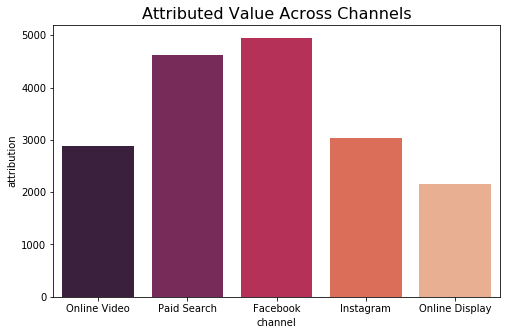

In [284]:
markov_chain = pd.DataFrame(list(markov_chain_allocation.items()), columns=['channel', 'attribution'])
fig, ax = plt.subplots(figsize=(8, 5))
ax = sns.barplot(x="channel", y="attribution", data=markov_chain, estimator=np.median, palette='rocket')
plt.title('Attributed Value Across Channels', fontsize=16)
plt.show()

Facebook has the highest attributed value out of five channels.

#### Reference 

https://towardsdatascience.com/marketing-channel-attribution-with-markov-chains-in-python-part-2-the-complete-walkthrough-733c65b23323